# Test optimizer on simple problem

The aim is to solve quadratic equation of form
$$
L(x) = \frac{1}{2} x^T Q x + b^T x
$$
where $Q$ is random positive-definite matrix, $b$ is a random vector. 

In [1]:
import tensorflow as tf

/home/mkk/anaconda3/envs/shelfwise_kk/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("../src/")
import tf_optimizer as tf_opt
from plotting import set_display_settings

set_display_settings()

# Generate problem (N=100)

In [4]:
import sklearn.datasets as sk_datasets
# dimensionality of the problem
ndims = 100
# Q [ndims, ndims] symetric positive define matrix
Q = sk_datasets.make_spd_matrix(ndims).astype(np.float32)
# b random vector of shape [ndims, 1]
b = np.random.randn(ndims, 1).astype(np.float32)
# w0 initial state of the unknown variable, vector of shape [ndims, 1]
w0 = np.random.randn(ndims, 1).astype(np.float32)

In [5]:
# define loss function
def L(w0, Q, b):
    """Define loss function"""
    
    weights = tf.get_variable(
        name='w', 
        dtype=tf.float32, 
        initializer=w0)
        
    # 0.5 x^T Q x + b^T x
    loss = 0.5 * tf.matmul(tf.transpose(weights), tf.matmul(Q, weights)) \
         - tf.matmul(tf.transpose(b), weights)
    
    return tf.reshape(loss, (1,))

# Solve problem with `AdaptiveNormalizedSGD` optimizer

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

lr_np = 0.05
history = []
max_iter = 1500

# define optimizer
optimizer = tf_opt.AdaptiveNormalizedSGD(
    lr=lr_np,
    lr_update=0.02,
    lr_max=0.5, 
    lr_min=0.0, 
    momentum=0.9,
    momentum_update=0.002,
    norm_type='std', 
    noise_amplitude=0.0
)
  
loss = L(w0, Q, b)
update_op = optimizer.minimize(loss)
opt_vars = optimizer._lr_variables + optimizer._momentum_variables + [optimizer._grad_correlation_t]

sess.run(tf.global_variables_initializer())    
for i in range(max_iter):
    loss_np, _, *lr_ada = sess.run([loss, update_op] + opt_vars)        
    history.append([i, loss_np, *lr_ada])   
history = np.array(history)

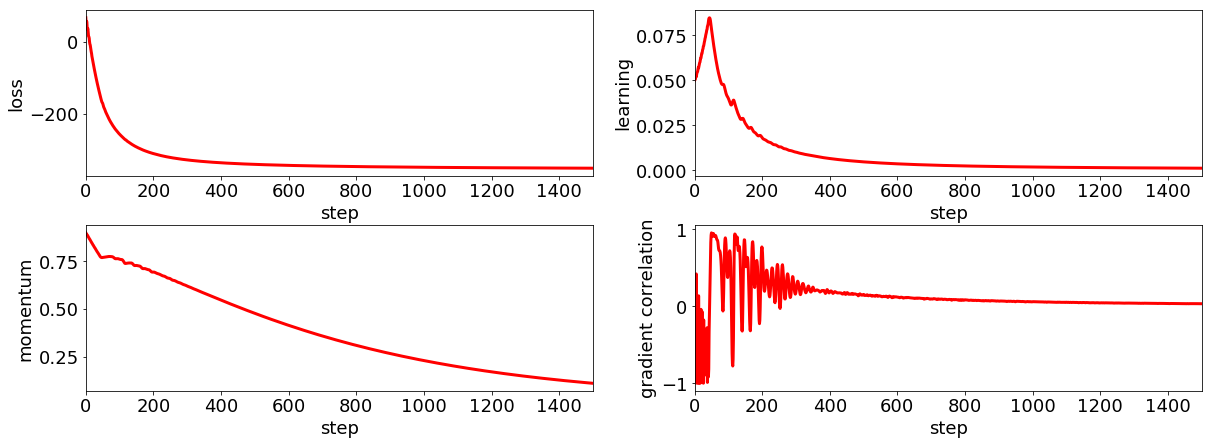

In [7]:
plt.figure(figsize=(20, 7))
plt.subplots_adjust(hspace=0.3)
def plot_hist(subplot, name, col):
    plt.subplot(subplot)
    plt.ylabel(name)
    plt.xlabel('step')
    plt.plot(history[:, 0], history[:, col], 'r-', lw=3)
    plt.xlim([0, max_iter])

plot_hist(subplot=221, name='loss', col=1)
plot_hist(subplot=222, name='learning', col=2)
plot_hist(subplot=223, name='momentum', col=3)
plot_hist(subplot=224, name='gradient correlation', col=4)

# plt.savefig("../img/adaptive_sgd.png")
# plt.savefig("../img/adaptive_sgd.pdf")

**Note: ** In the above the learning_rate is increasing at the begining, which means that initial value of it was too small. 

# Compare with Momentum and Adam optimizer for different initial values of learning_rate

In [8]:
def fit(optimizer: tf.train.Optimizer, scope: str):
    """Solve quadratic problem with given optimizer.
    Returns loss history.
    """
    history = []
    max_iter = 1000
    with tf.variable_scope(scope):
        loss = L(w0, Q, b)
        update_op = optimizer.minimize(loss)
        sess.run(tf.global_variables_initializer())    
        
    for i in range(max_iter):
        _= sess.run([update_op])        
        loss_np = sess.run(loss) 
        history.append([i, loss_np])   
    history = np.array(history)
    return history

Here I use momentum=0.9, since it was giving the best performing MomentumOptimizer. 
I also use the `std` normalization method, since for this case it was the most stable one.

In [9]:
comparisons = {}
min_value, max_value = 0, 0
for lr_np in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]:
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    print(f'lr={lr_np}')
    nsgd_optimizer = tf_opt.AdaptiveNormalizedSGD(
        lr=lr_np,
        lr_update=0.05, 
        lr_max=0.5, 
        lr_min=1e-6, 
        momentum=0.9,
        momentum_update=0.00001,
        norm_type='std', 
        noise_amplitude=0.0)

    momentum_opt = tf.train.MomentumOptimizer(lr_np, momentum=0.9)
    adam_opt = tf.train.AdamOptimizer(lr_np, beta1=0.9)

    hist_nsgd = fit(nsgd_optimizer, 'NSGD')
    hist_adam = fit(adam_opt, 'Adam')
    hist_momentum = fit(momentum_opt, 'Momentum')
    
    comparisons[lr_np] = {
        'NSGD': hist_nsgd,
        'Adam': hist_adam,
        'Momentum': hist_momentum,
    }
    # keep min max for plotting reasons
    min_value = min(np.min(hist_nsgd), min_value)
    max_value = max(np.max(hist_nsgd), max_value)

lr=0.001
lr=0.005
lr=0.01
lr=0.03
lr=0.05
lr=0.1


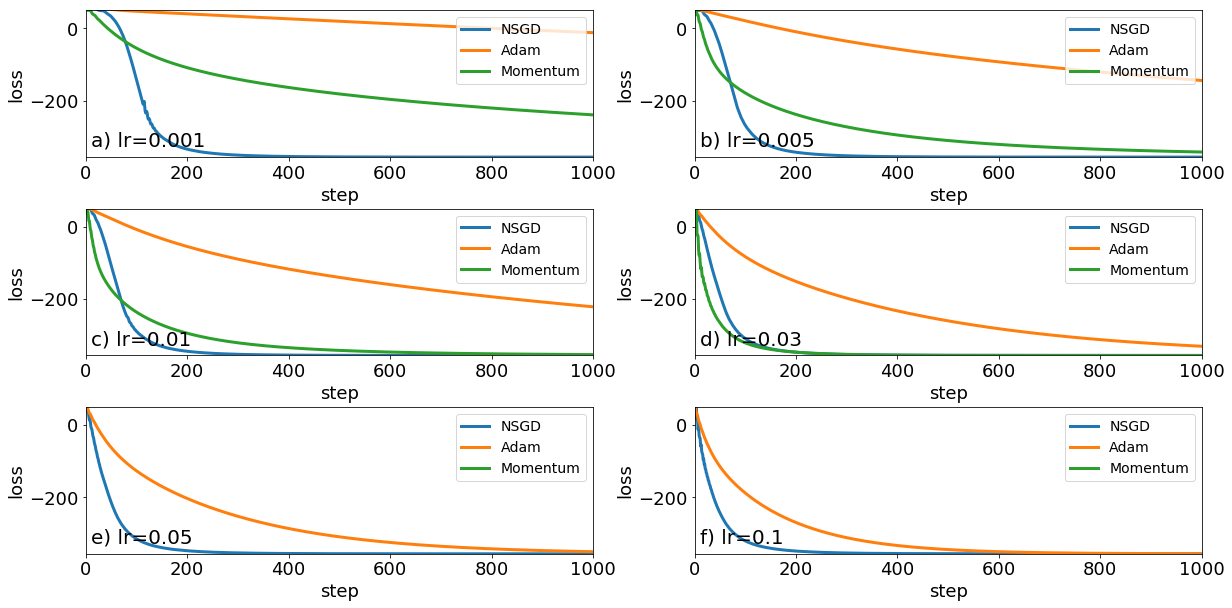

In [10]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.35)

for k, (lr, hists) in enumerate(comparisons.items()):    
    plt.subplot(len( comparisons.items())//2, 2, k + 1)
    plt.text(10, min_value+30, f'{chr(ord("a") + k)}) lr={lr}', size=20)
    for opt, hist in hists.items():        
        plt.plot(hist[:, 0], hist[:, 1], label=opt, lw=3)
    plt.legend(loc='upper right', fontsize=14)
    plt.ylim([min_value, 50])
    plt.xlim([0, 1000])
    plt.ylabel('loss')
    plt.xlabel('step')
    
# plt.savefig("../img/opt_cmp1.png")
# plt.savefig("../img/opt_cmp1.pdf")

# Dependency on initial choice of learning_rate

/home/mkk/anaconda3/envs/shelfwise_kk/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


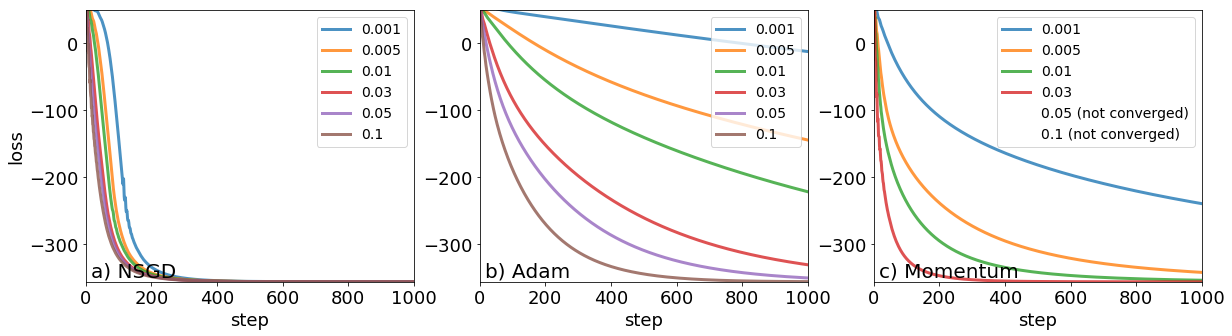

In [11]:
plt.figure(figsize=(20, 5))
for s, opt in enumerate(['NSGD', 'Adam', 'Momentum']):
    plt.subplot(1, 3, s + 1)        
    plt.text(15, min_value+0.02*abs(min_value), f'{chr(ord("a") + s)}) {opt}', size=20)
    for k, (lr, hists) in enumerate(comparisons.items()):  
        label = f'{lr}' if hists[opt][-100:, 1].max() < 0 else f'{lr} (not converged)'
        if hists[opt][-100:, 1].max() < 0:
            plt.plot(hists[opt][:, 0], hists[opt][:, 1], label=label, lw=3, alpha=0.8)
        else:
            plt.plot(hists[opt][:, 0], hists[opt][:, 1]*0, label=label, alpha=0.0)
    plt.legend(loc='upper right', fontsize=14)
    plt.ylim([min_value, 50])    
    plt.xlim([0, 1000])
    plt.xlabel('step')
    if s == 0: plt.ylabel('loss')
        
# plt.savefig("../img/opt_cmp2_lr.png")
# plt.savefig("../img/opt_cmp2_lr.pdf")